In [1]:
# Expand the view to scale with window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<h1 align="center">
The Green-Naghdi Equations with Variable Topography
</h1>
<h2 align="center">
Adam Morgan
</h2>



## Model Equations ##
The one-dimensional Green-Naghdi model with topography may be written as a system of three coupled nonlinear PDEs :

\begin{align}
h\ v = h\ u+  \gamma \left[-\frac{1}{3} \partial_{x}\left(h^{3} \ \partial_{x}u\right) -\frac{1}{2} \partial_{x}\left(h^{2} \ u \ \partial_{x}H\right)  + \frac{1}{2} h^{2} \ \partial_{x}u \ \partial_{x}H  +h\  u \ \left(\partial_{x}H\right)^{2}\right],
\end{align}

\begin{align}
\partial_t v + \partial_{x}\left(\frac{1}{\mathrm{Fr}^{2}} \ \eta -\frac12 u^2 +uv -\frac{\gamma}{2} \left(h \ \partial_{x}u+u \ \partial_{x}H\right)^2\right)
- \frac{1}{\mathrm{Re}} \ \partial_{xx} v = 0, \quad \text{and}
\end{align}

\begin{align}
\partial_t h & +  \partial_x \left(h u \right) = 0. 
\end{align}

The parameters and unitless variables are 

* $\mathrm{Fr}$ is the Froude number (representing how fast a typical disturbance travels relative to a linear gravity wave), 
* $\mathrm{Re}$ is the Reynolds number, 
* $\gamma$ is the aspect ratio squared, 
* $H(x)$ is the undisturbed depth of the fluid (representing the influence of topography), 
* $\eta(x,t)$ is the deformation of the surface, 
* $h(x,t) = H(x) + \eta(x,t)$ is the total depth of the fluid,
* $u(x,t)$ is the velocity of the fluid in the x-direction.
* $v(x,t)$ is the pseudovelocity, a variable arising from the Hamiltonian description of the dynamics. 

In the small aspect-ratio limit, $v=u$ and the Green-Naghdi equations reduce to the shallow water equations.   

We demand that the velocity and pseudovelocity vanish at either wall:
$$
u(0,t)= v(0, t) = 0,
\quad \mbox{ and } \quad
u(L_x, t) = v(L_x, t)= 0.
$$

We must also prescribe the values of $h(x,0)$ and $u(x,0)$. 

# Summary of Numerical Method #
Consulting the Periodic Table, we see that our only choice of spaces is summarized in the de Rham diagram 
$$\mathrm{CG}(r)\xrightarrow{\partial_{x}}\mathrm{DG}(r-1).$$ 
We choose $u,v \in \mathrm{CG}(r)$ and $h\in \mathrm{DG}(r-1)$. We also define an auxiliary numerical flux $F\in \mathrm{CG}(r)$ in order to improve the routine's ability to mimic energy conservation. 

Using continuous test functions $\lambda, \mu$, and $\xi$ and a discontinuous test function $\beta$, our weak form of the 1D GN is 
\begin{equation}
\int_{0}^{L_{x}} \lambda \ (hv-F) \ \mathrm{d} x = \gamma \int_{0}^{L_{x}} \frac13 \ h^{3}  \ \partial_{x}\lambda \ \partial_{x}u + \frac12 \ h^{2} \ u \ \partial_{x}H \ \partial_{x}\lambda +\frac12 h^{2} \ \lambda \ \partial_{x}u \ \partial_{x}H + \lambda \ u \ h \  \left(\partial_{x}H\right)^2\ \mathrm{d} x,
\end{equation}

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d} t}\int_{0}^{L_{x}} \mu \ v  \ \mathrm{d} x -\int_{0}^{L_{x}}\left(\partial_{x}\ \mu\right) \ \left(\frac{1}{\mathrm{Fr}^{2}} \ \eta-\frac{1}{2} u^{2}+uv - \frac{\gamma}{2} \left(h \ \partial_{x}u+u \ \partial_{x}H\right)^2\right) - \frac{1}{\mathrm{Re}} \ \partial_{x} \ \mu \ \partial_{x}v \ \mathrm{d} x = 0,
\end{equation}

\begin{equation}
\int_{0}^{L_{x}} F \ \xi \ \mathrm{d} x = \int_{0}^{L_{x}} h \ u \ \xi \ \mathrm{d} x,
\end{equation}

\begin{equation} 
\frac{\mathrm{d}}{\mathrm{d} t} \int_{0}^{L_{x}} \beta \ \eta \ \mathrm{d} x - \int_{0}^{L_{x}} \beta \ \partial_{x}F = 0. 
\end{equation}
We discretize in time using the Implicit Midpoint Rule. 

# Numerical Solution#

#### Import Libraries

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
from IPython.display import HTML
import sys

/Users/a24morga/firedrake/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
T = 60.          # Final time when the simulation stops. You may need to make this bigger to see certain features.

Lx = 80.0       # Length of domain
Nx = 500         # Number of elements

ReInv = 0.00        #1/Re, set to 0 for inviscid dynamics 
gamma = 1.00     # Aspect ratio squared

deg  = 1         # Degree of continuous approximating functions

#### Create the grid

Since we have walls at the two ends we impose no-normal flow boundary conditions, i.e. $u=0$ at the two ends.

In [4]:
mesh = IntervalMesh(Nx, Lx)
x = SpatialCoordinate(mesh)

# Function Spaces and grid
V1 = FunctionSpace(mesh, "CG", deg)         # Space for velocity: u, v, F 
V2 = FunctionSpace(mesh, "DG", deg-1)       # Space for height: h
W  = MixedFunctionSpace([V1,V1,V1,V2])      # Making a combined function space by taking the disjoint direct sum

w0 = Function(W)                       # Solution at known time
u0, v0, F0, h0 = w0.split()            # Resolve solution into its three components

# Translate grid as a vector
xdata = interpolate(Expression("x[0]"),V2).vector().array()[1:]
xplot = np.linspace(0, Lx, Nx)


#### Set the boundary conditions

In [5]:
# Dirichlet Boundary Conditions on u
ubcLeft  = DirichletBC(W.sub(0), Constant(0.0), 1)
ubcRight = DirichletBC(W.sub(0), Constant(0.0), 2)

# Dirichlet Boundary Conditions on v
vbcLeft  = DirichletBC(W.sub(1), Constant(0.0), 1)
vbcRight = DirichletBC(W.sub(1), Constant(0.0), 2)

# Dirichlet Boundary Conditions on F
FbcLeft  = DirichletBC(W.sub(2), Constant(0.0), 1)
FbcRight = DirichletBC(W.sub(2), Constant(0.0), 2)

bcs = [ubcLeft, ubcRight, vbcLeft, vbcRight, FbcLeft, FbcRight]
# Note: ("1" for left and "2" for right)    

In [6]:
# Define depth/topography parameters. 

H0 = 1.             # Average of depth
H = Function(V2)    # Undisturbed depth
Hm  = Function(V2)  #-H

# Topography Parameters (these have to be defined here for cleanliness reasons)
##################################################################
ramp_on = 0.0       # 1 for Case 1, 0 otherwise

slope = -0.8*H0/Lx  # Slope of bottom in rising hill case (Case 1)

##################################################################
bump_on = 0.0    # 1 for Case 2, 0 otherwise

bump_amp = 0.6  # Amplitude of the single hill in Case 2, as a fraction of H0

bump_width = 0.1   # Smaller bump_width gives a wider hill in Case 2

##################################################################
shelf_width= 1. # Width parameter for the continental shelf (Case 3). 
                 #The smaller shelf_width is, the faster the jump in topography

shelf_on = 0.0   # 1 for Case 3, 0 otherwise

##################################################################
num_waves = 6.0 # Number of crests and troughs in Case 4

sine_amp = 0.2  # Amplitude of the little hills in Case 4, as a fraction of H0

sine_on = 0.0   # 1 for Case 4, 0 otherwise

Now, we specify the bottom topography by choosing the number TopType to be 1,2,3, or 4. TopType=1 gives a linear ramp, TopType=2 gives a single Gaussian hill, TopType=3 gives a continential shelf, and TopType=4 gives a sinusoidal bottom topography with "num_waves" troughs and crests. 

In [7]:
TopType = 1

if TopType == 1 :
    ramp_on = 1.0 
    
    H.interpolate(Expression(" H0 + slope*x[0]", Lx=Lx, H0=H0, slope=slope));
    Hm.interpolate(Expression(" -H0 - slope*x[0]", Lx=Lx, H0=H0, slope=slope));
    
elif TopType == 2 :
    bump_on = 1.0

    Hm.interpolate(Expression("-H0+H0*bump_amp*exp(-bump_width*pow(x[0]-0.5*Lx,2))", H0=H0, Lx=Lx, bump_width=bump_width, bump_amp=bump_amp))
    H.interpolate(Expression("H0-H0*bump_amp*exp(-bump_width*pow(x[0]-0.5*Lx,2))", H0=H0, Lx=Lx, bump_width=bump_width, bump_amp=bump_amp))

elif TopType == 3 :
    shelf_on = 1.0 

    H.interpolate(Expression(" H0 - 0.3*H0*tanh((x[0]-0.6*Lx)/(shelf_width)) ", Lx=Lx, H0=H0, shelf_width=shelf_width));
    Hm.interpolate(Expression(" - H0 +  0.3*H0*tanh((x[0]-0.6*Lx)/(shelf_width)) ", Lx=Lx, H0=H0, shelf_width=shelf_width));

elif TopType == 4 :
    # You may have to turn on viscosity in this case to make the pictures a little less noisy
    # and make the energy behave more nicely. 
    sine_on = 1.0 
    
    H.interpolate(Expression("H0-sine_amp*sin(2*pi*num_waves*x[0]/Lx)",H0=H0, Lx=Lx, sine_amp=sine_amp, num_waves=num_waves));
                             
    Hm.interpolate(Expression("-H0+sine_amp*sin(2*pi*num_waves*x[0]/Lx)",H0=H0, Lx=Lx, sine_amp=sine_amp, num_waves=num_waves));

Hp = np.zeros((1,Nx))
Hp = Hm.at(xplot, tolerance=1e-12)

#### Compute time step and temporal grid

In [8]:
# Time step and grid
dt = (0.8)*Lx/Nx

Dt = Constant(dt)
Nt = np.int(T/dt)
tt = np.linspace(0., T, Nt+1)

Nskip = 1
Nplot = round(Nt/Nskip)
tplot = np.linspace(0., T, Nplot+1)

In [9]:
eta0  = Function(V2)    # Free surface deformation

Hinf = H0 - shelf_on*0.3*H0*tanh((-0.6*Lx)/(shelf_width))  # Layer depth at infinity

Hcrest = Hinf + 0.2  # Layer depth of at the solitary wave crest

Arg = 0.5*sqrt((3*(Hcrest-Hinf))/(Hcrest*Hinf*Hinf))  # Parameter appearing in the solution, define for cleanliness

Frac = 0.2 # x[0]=Frac*Lx is where the crest of the wave is initially located

# Unfortunately, the errors associated in repeatedly interpolating cause bad problems so a direct input is an unfortunate necessity. 
# That is, we can't just define eta0 and use that to define h0 and u0, we have to re-input the UFL expression every time 
# else we get a solution with visible dispersion.

eta0.interpolate(Expression("(Hcrest-Hinf)/pow(cosh((x[0]-Frac*Lx)*Arg),2)", Hinf=Hinf, Hcrest=Hcrest, Arg=Arg, Lx=Lx, Frac=Frac));

etap = np.zeros((1,Nx))
etap = eta0.at(xplot, tolerance=1e-12)

#h0.assign(H);
h0.interpolate(H0 - shelf_on*0.3*H0*tanh((x[0]-0.6*Lx)/(shelf_width))
               + ramp_on*slope*x[0] 
               - bump_on*bump_amp*H0*exp(-bump_width*(x[0]-0.5*Lx)**2) 
               - sine_on*sine_amp*sin(2*pi*num_waves*x[0]/Lx)
               + (Hcrest-Hinf)/pow(cosh((x[0]-Frac*Lx)*Arg),2));
    
hp = np.zeros((1,Nx))
hp = h0.at(xplot, tolerance=1e-12) 

# cRough = sqrt(g*Hcrest) is the new velocity scale)
#u0.interpolate(Expression("0.0"));
u0.interpolate(Expression("(1.0-Hinf/( Hinf +(Hcrest-Hinf)/pow(cosh((x[0]-Frac*Lx)*Arg),2)))", H0=H0, shelf_width=shelf_width,Hinf=Hinf, Hcrest=Hcrest, Arg=Arg, Lx=Lx, Frac=Frac));

In [10]:
# Define Froude Number 
Fr =sqrt(Hcrest/Hinf)      # Froude number 


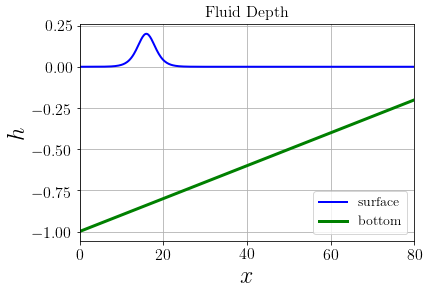

In [11]:
# Plot initial h profile along with the bottom
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)

plt.figure()
plt.clf()
plt.plot(xplot,etap,'-b',lw=2,label='surface')
plt.plot(xplot,Hp,'-g',lw=3,label='bottom')
plt.grid('on')
plt.title('Fluid Depth', fontsize=16)
plt.xlim([0, Lx])
plt.xlabel('$x$', fontsize='24')
plt.ylabel('$h$', fontsize='24')
plt.grid('on')
plt.legend(loc='best', prop={'size': 14})
plt.tick_params(axis='x', which='both', top='off', labelsize= 16)
plt.tick_params(axis='y', which='both', right='off', labelsize= 16)
plt.show()

In [12]:
#Dirichlet Boundary Conditions
v0bcLeft  = DirichletBC(V1, Constant(0.0), 1)
v0bcRight = DirichletBC(V1, Constant(0.0), 2)

v0bcs = [v0bcLeft, v0bcRight]

#Computing initial mass flux
F = TrialFunction(V1)
xi = TestFunction(V1)

amass = (xi*F)*dx
Lmass = (xi*h0*u0)*dx

solve(amass==Lmass, F0, bcs=v0bcs, solver_parameters={'ksp_type': 'preonly','pc_type': 'lu'})

In [13]:
# Solve problem for the pseudovelocity 

Lambda = TestFunction(V1)
v = TrialFunction(V1)

av = Lambda*v*h0*dx
Lv = (Lambda*F0 + gamma*((1./3)*Lambda.dx(0)*u0.dx(0)*h0**3
+0.5*((h0**2)*(H.dx(0))*u0*Lambda.dx(0))
+0.5*Lambda*u0.dx(0)*H.dx(0)*(h0**2)
+Lambda*u0*h0*(H.dx(0))**2))*dx

solve(av == Lv, v0, bcs=v0bcs, solver_parameters={'ksp_type': 'preonly','pc_type': 'lu'})

In [14]:
#Unknown solution
w1     = Function(W)    
u1, v1, F1, h1 = w1.split()                 # Split into three variables
w1.assign(w0)                           # Guess that w1=w0 to initialize

#Now, we use another type of "splitting" so that we can put our variables into the expression of our nonlinear form F. 
u0, v0, F0, h0 = split(w0)
u1, v1, F1, h1 = split(w1)

In [15]:
# Define test and trial functions
Lambda, mu, xi, beta = TestFunctions(W)

# Defining field variables at mid-times (because we want to discretize with the implicit midpoint rule)
uz = 0.5*(u1 + u0)
vz = 0.5*(v1 + v0)
Fz = 0.5*(F1 + F0)
hz = 0.5*(h1 + h0)

In [16]:
# Define weak form as a nonlinear form equation Fop((u,v,h),(Lambda,mu,beta))=0 
Fop = (
(dot(Lambda,h1*v1-F1) 
- gamma*((1.0/3.0)*Lambda.dx(0)*u1.dx(0)*h1**3
-0.5*(h1**2)*(H.dx(0))*u1*(Lambda.dx(0))
-0.5*(u1.dx(0))*(H.dx(0))*(h1**2)*Lambda-Lambda*u1*h1*((H.dx(0))**2)))*dx

+(beta*(h1-h0) + Dt*beta*Fz.dx(0))*dx

+(mu*(v1 - v0) - Dt*(mu.dx(0))*((1/Fr**2)*(hz-H)-0.5*(uz**2)+uz*vz-gamma*0.5*(hz*uz.dx(0)+uz*H.dx(0))**2)
+ Dt * ReInv * ( uz.dx(0) * mu.dx(0))) * dx

+(dot(xi,F1-h1*u1))*dx
)

In [17]:
#Define nonlinear problem to solve at every time-step

problem = NonlinearVariationalProblem(Fop, w1, bcs=bcs)

params={'mat_type': 'aij','ksp_type': 'preonly','pc_type': 'lu','pc_factor_mat_solver_package': 'mumps'}

solver = NonlinearVariationalSolver(problem, solver_parameters=params) 

#### Create arrays to store the solution

In [18]:
# Split variables again, this time with the goal of accessing the data from the entries  
u0, v0, F0, h0 = w0.split()
u1, v1, F1, h1 = w1.split()

etasoln = np.zeros((Nplot+1,Nx))
etasoln[0,:] = eta0.at(xplot, tolerance=1e-12)

Estore = np.zeros((Nt+1,1))
Estore[0] = assemble(0.5*((1/Fr**2)*(h0-H)**2 + h0*u0*v0)*dx)

# Uncomment to get error for still--water tests
Errorstore = np.zeros((Nt+1,1))
Errorstore[0] =sqrt(assemble((h0-H)**2*dx))

#### Loop over the time-steps, storing h as we go

In [19]:
for cnt in range(1,Nt+1):
    
    t = cnt*dt

    solver.solve()
    w0.assign(w1)
    
    E = assemble(0.5*((1/Fr**2)*(h0-H)**2 + h0*u0*v0)*dx)
    #Error = sqrt(assemble((h0-H)**2*dx))

    Estore[cnt]=E
    #Errorstore[cnt]=Error 
   
    if (np.mod(cnt,Nskip)) == 0:
        eta0.assign(h0 - H)
        etasoln[round(cnt/Nskip),:] = eta0.at(xplot, tolerance=1e-12)

#### Hovmoeller Plot of h

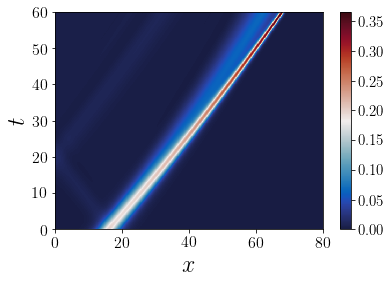

In [20]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)

plt.pcolormesh(xplot,tplot, etasoln, cmap = cmocean.cm.balance) ;

CB = plt.colorbar();
CB.ax.tick_params(labelsize=15)
plt.xlabel("$x$", fontsize='24')
plt.ylabel("$t$", fontsize='24')
plt.ylim([0,60])
plt.tick_params(axis='x', which='both', top='off',labelsize=16)
plt.tick_params(axis='y', which='both', right='off',labelsize=16)
#plt.title("Evolution of Free Surface Deformation $\eta$", fontsize='16')
plt.show();

plt.figure();

/Users/a24morga/firedrake/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


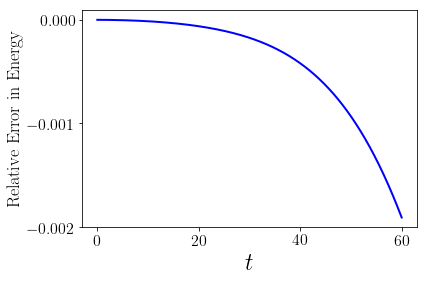

In [21]:
#PLOT OF RELATIVE ERROR IN THE ENERGY
plt.figure()
plt.plot(tt, (Estore-Estore[0])/Estore[0], linewidth=2, color='b') #/Estore[0]
ax = plt.subplot(1,1,1)

plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'Relative Error in Energy', fontsize=18) # ($10^3$)
#plt.xlim([0,80])
#plt.ylim([-1.22, 0.05])

plt.tick_params(axis='x', which='both', top='off', labelsize= 16)
plt.tick_params(axis='y', which='both', right='off', labelsize= 16)
plt.locator_params(axis='y', nbins=4) # Number of bins between tick marks (nticks=nbins+1)
plt.locator_params(axis='x', nbins=4)
#fignamepng = 'EnergyError_StillWater'+'.png'
#plt.savefig(fignamepng)
#plt.show()

#### Make Animation

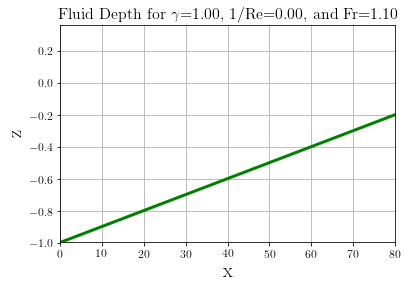

In [22]:
fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(np.min(Hp),1.8*(Hcrest-Hinf))) 
ax.grid('on')
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('z',fontsize=20)
plt.tick_params(axis='x', which='both', top='off', labelsize= 12)
plt.tick_params(axis='y', which='both', right='off', labelsize= 12)
#plt.tight_layout()

movie_title = "Fluid Depth for $\gamma$=%.2f, $1/\mathrm{Re}$=%.2f, and $\mathrm{Fr}$=%.2f" % (gamma, ReInv, Fr)
plt.title(movie_title,fontsize=16)

line2, = ax.plot(xplot,Hp, '-g',lw=3)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    #line.grid('on')
    return line,

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xplot, etasoln[i,:])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nplot, interval=20, blit=True)

In [23]:
HTML(anim.to_html5_video())

In [24]:
anim.save('Wave_Topography.mp4', fps=40, extra_args=['-vcodec', 'libx264'])

In [25]:
#filename ='WaveTop_deg=%d_N=%d_gamma=%3f' % (deg, Nx, gamma) + '.npz'
#np.savez(filename, etasoln=etasoln, Estore=Estore)